<a href="https://colab.research.google.com/github/Pakeith0805/SparkPlus_Assignment/blob/staging/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SparkPlusの採用課題です。

- ラベル「0」： airplane（飛行機）
- ラベル「1」： automobile（自動車）
- ラベル「2」： bird（鳥）
- ラベル「3」： cat（猫）
- ラベル「4」： deer（鹿）
- ラベル「5」： dog（犬）
- ラベル「6」： frog（カエル）
- ラベル「7」： horse（馬）
- ラベル「8」： ship（船）
- ラベル「9」： truck（トラック）

# 前処理

In [143]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
import torch.nn.functional as F

In [144]:
# ちゃんとgpuになってるか確認。
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [145]:
# 前処理をまとめる
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # ランダムに左右対称にする
    transforms.ColorJitter(), # ランダムに色を変える。
    transforms.ToTensor(), # 画像をTensorクラスに変えて、チャネルファーストに変えてくれる。
    transforms.Normalize((0.5,), (0.5,)) # 平均、標準偏差を0.5に
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 訓練用データセットと検証用データセットを作成
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
vilidation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_transform)

In [146]:
# データを作る。
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(vilidation_dataset, batch_size=32, shuffle=False)

In [147]:
# CNNを実装。
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2), # RGBなのでin_channelsは3、畳み込むたびに2ずつ画像が小さくなるため、2補う。
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 32×32の画像が16×16になる。
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), # RGBなのでin_channelsは3、畳み込むたびに2ずつ画像が小さくなるため、2補う。
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 16×16の画像が8×8になる。
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1), # RGBなのでin_channelsは3、畳み込むたびに2ずつ画像が小さくなるため、2補う。
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 8×8の画像が4×4になる。
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1), # RGBなのでin_channelsは3、畳み込むたびに2ずつ画像が小さくなるため、2補う。
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Linear(in_features=4 * 4 * 128, out_features=num_classes) # in_featuresには1次元ベクトルにして渡す。4×4が128個ある。out_featuresは何個に分類するか。
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # x.size(0)はバッチ数を表す。(32, 4×4×128)という形になる。
        x = self.classifier(x)
        return x

In [148]:
# modelを作成
model = CNN(10) # 10はクラス数
model.to(device)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
  )
  (classifier): Linear(in_features=2048, out_features=10, bias=True)
)

In [149]:
# 損失関数とoptimizerを設定
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4) # weight_decayで重みづけが大きくなりすぎないようにしている。
# CosineAnnealingWarmRestartsの設定
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=0.)

In [150]:
num_classes=10

In [151]:
# 学習のループ
num_epochs = 25
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs-3):
    total_loss = 0.0 # mixupでは損失の計算方法が異なるため、total_lossに名称変更
    total_acc = 0.0
    y_true = []  # 正解ラベルを保存
    y_pred = []  # 予測ラベルを保存
    for imgs, labels, in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        # こっからmixup
        lmd = np.random.beta(1.0, 1.0)
        idx = torch.randperm(imgs.size(0)).to(device) # ランダムに並び替える
        imgs2 = imgs[idx, :] # 混ぜ合わせる画像
        labels2 = labels[idx]

        labels = F.one_hot(labels, num_classes=num_classes).float()
        labels2 = F.one_hot(labels2, num_classes=num_classes).float()

        # ここまで

        optimizer.zero_grad() # 勾配の初期化
        output = model(lmd * imgs + (1 - lmd) * imgs2) # いじった
        loss = lmd * criterion(output, labels) + (1 - lmd) * criterion(output, labels2) # いじった
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        prob_pred = torch.softmax(output, dim=1)
        total_acc += lmd * torch.mean(pred.eq(labels.argmax(dim=1)).float()) + (1 - lmd) * torch.mean(pred.eq(labels2.argmax(dim=1)).float())
        y_true.extend(labels.cpu().numpy())  # GPU->CPU
        y_pred.extend(pred.cpu().numpy())  # GPU->CPU
    total_loss /= len(train_dataloader)
    total_acc /= len(train_dataloader)
    losses.append(total_loss)
    #accs.append(running_acc)
    accs.append(total_acc.cpu())
    scheduler.step()
#
# validationのループ
#
    val_running_loss = 0.0
    val_running_acc = 0.0
    y_val_true = []  # 正解ラベルを保存
    y_val_pred = []  # 予測ラベルを保存
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())
        # ラベルを保存
        y_val_true.extend(val_labels.cpu().numpy())  # GPU->CPU
        y_val_pred.extend(val_pred.cpu().numpy())  # GPU->CPU

    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    #val_accs.append(val_running_acc)
    val_accs.append(val_running_acc.cpu())
    print("epoch: {}, loss: {}, acc: {}, \
     val loss: {}, val acc: {}".format(epoch, total_loss, total_acc, val_running_loss, val_running_acc))




for epoch in range(num_epochs-12):
    running_loss = 0.0
    running_acc = 0.0
    y_true = []  # 正解ラベルを保存
    y_pred = []  # 予測ラベルを保存
    for imgs, labels, in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() # 位置換えてみた
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        prob_pred = torch.softmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())
        y_true.extend(labels.cpu().numpy())  # GPU->CPU
        y_pred.extend(pred.cpu().numpy())  # GPU->CPU
    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    #accs.append(running_acc)
    accs.append(running_acc.cpu())
    scheduler.step()
#
# validationのループ
#
    val_running_loss = 0.0
    val_running_acc = 0.0
    y_val_true = []  # 正解ラベルを保存
    y_val_pred = []  # 予測ラベルを保存
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())
        # ラベルを保存
        y_val_true.extend(val_labels.cpu().numpy())  # GPU->CPU
        y_val_pred.extend(val_pred.cpu().numpy())  # GPU->CPU

    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    #val_accs.append(val_running_acc)
    val_accs.append(val_running_acc.cpu())
    print("epoch: {}, loss: {}, acc: {}, \
     val loss: {}, val acc: {}".format(epoch+12, running_loss, running_acc, val_running_loss, val_running_acc))

epoch: 0, loss: 1.8289092800133668, acc: 0.3574104607105255,      val loss: 1.3886674446419787, val acc: 0.5181708931922913
epoch: 1, loss: 1.5818792307369234, acc: 0.4759492874145508,      val loss: 1.012923038043915, val acc: 0.6660343408584595
epoch: 2, loss: 1.4536653596547957, acc: 0.5347370505332947,      val loss: 0.9175318049165768, val acc: 0.7107627391815186
epoch: 3, loss: 1.3983377212526245, acc: 0.5572270154953003,      val loss: 0.818263471697847, val acc: 0.7390175461769104
epoch: 4, loss: 1.3356052259947349, acc: 0.5850823521614075,      val loss: 0.769560479222776, val acc: 0.7595846652984619
epoch: 5, loss: 1.4146233022556196, acc: 0.5530678033828735,      val loss: 0.8192842151410282, val acc: 0.7367212176322937
epoch: 6, loss: 1.4065091736943616, acc: 0.5594924688339233,      val loss: 0.8798397630929186, val acc: 0.7216453552246094
epoch: 7, loss: 1.354234811040124, acc: 0.5788453221321106,      val loss: 0.8028332928118234, val acc: 0.7449081540107727
epoch: 8, lo

In [152]:
labels

tensor([5, 3, 5, 7, 7, 9, 8, 9, 7, 7, 5, 5, 6, 3, 7, 8], device='cuda:0')

In [153]:
one_zero_labels = torch.where(labels == 0, 1, 0)
print(one_zero_labels)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


In [154]:
prob = prob_pred[:, 0]

In [155]:
prob
# probはラベル0の確率。これ使ってroc曲線かける

tensor([1.1375e-02, 3.2424e-08, 1.3998e-05, 1.3716e-05, 5.3560e-07, 1.0940e-08,
        3.1157e-05, 5.3469e-07, 9.1240e-12, 1.5017e-06, 4.3830e-07, 1.3741e-06,
        9.0747e-07, 5.3551e-07, 2.3118e-07, 4.6111e-03], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [156]:
roc = roc_curve(one_zero_labels.cpu().detach().numpy(), prob.cpu().detach().numpy())

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


In [157]:
fpr, tpr, thresholds = roc

print(fpr)
# [0.   0.   0.25 0.25 0.5  0.5  1.  ]

print(tpr)
# [0.   0.25 0.25 0.5  0.5  1.   1.  ]

print(thresholds)
# [1.9 0.9 0.8 0.7 0.6 0.4 0.2]

[0.     0.0625 1.    ]
[nan nan nan]
[          inf 1.1375344e-02 9.1239837e-12]


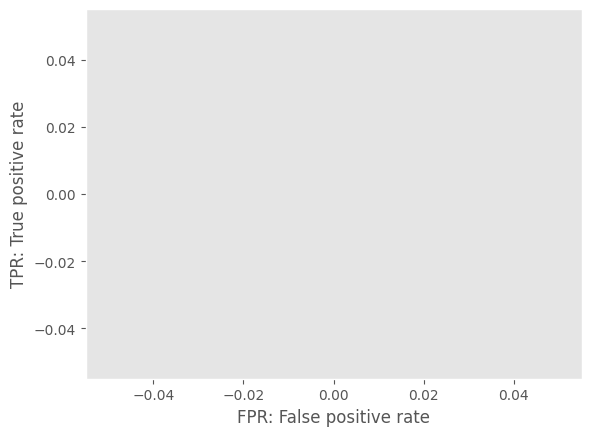

In [158]:
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

# 評価項目

In [159]:
# 正解率
print(accs[-1].cpu())
print(val_accs[-1].cpu())
# 混同行列
cm=confusion_matrix(y_true, y_pred)
val_cm=confusion_matrix(y_val_true, y_val_pred)
print(cm)
print(val_cm)
# 再現率：実際に真だったもののうち、モデルが真と判断した割合。
# 見逃しをなくしたいときに使われる。
# 別名真陽性率。
recall_per_class = cm.diagonal() / cm.sum(axis=1)
val_recall_per_class = val_cm.diagonal() / val_cm.sum(axis=1)
print(recall_per_class)
print(val_recall_per_class)
# 適合率：モデルが真と判断し、実際に真だった割合。猫と判断し、実際に猫だった割合。
# 誤検出をなくしたいときに使われる。
precision_per_class = cm.diagonal() / cm.sum(axis=0)
val_precision_per_class = val_cm.diagonal() / val_cm.sum(axis=0)
print(precision_per_class)
print(val_precision_per_class)
# F1スコア：適合率と再現率の調和平均。
f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class)
val_f1_per_class = 2 * (val_precision_per_class * val_recall_per_class) / (val_precision_per_class + val_recall_per_class)
print(f1_per_class)
print(val_f1_per_class)
# 偽陽性率：実際に偽だったったもののうち、モデルが間違えて真と判断した割合。

tensor(0.9539)
tensor(0.8362)
[[4837    4   40   29   15    8    2    6   41   18]
 [   6 4929    2    4    1    5    4    1   10   38]
 [  63    3 4681   66   69   43   42   16   10    7]
 [  33    2   69 4499   62  221   64   32    9    9]
 [  16    1   59   64 4750   42   18   43    6    1]
 [   9    3   56  269   65 4527   15   46    4    6]
 [   5    2   40   57   26   17 4841    7    4    1]
 [   8    3   20   56   44   33    6 4826    1    3]
 [  29   16    8    9    4    1    4    4 4908   17]
 [  22   37    8    9    1    2    6    6   12 4897]]
[[856  10  37  17   7   2   3   5  41  22]
 [ 10 916   4   1   1   2   2   2  18  44]
 [ 33   2 775  37  49  43  34  17   6   4]
 [ 24   4  45 675  37 129  39  29  11   7]
 [ 11   1  48  37 814  24  27  32   5   1]
 [ 10   3  33 116  31 765  11  25   2   4]
 [  4   1  33  37  26  14 878   3   3   1]
 [  8   1  15  21  29  40   2 879   2   3]
 [ 40  16   6   4   3   5   7   4 900  15]
 [ 20  36   6   6   3   2   4   7  13 903]]
[0.9674 

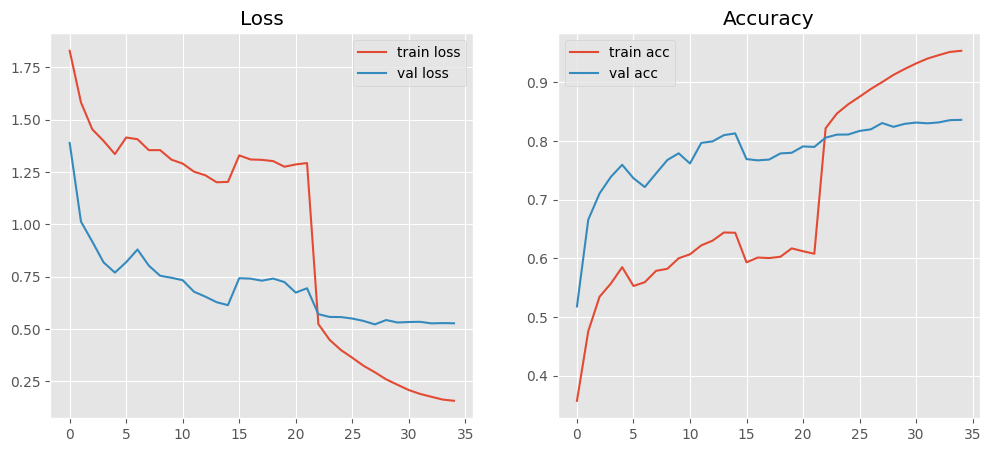

In [160]:
plt.style.use("ggplot")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1行2列のサブプロット

# 左のグラフ(損失)
axes[0].plot(losses, label="train loss")
axes[0].plot(val_losses, label="val loss")
axes[0].legend()
axes[0].set_title("Loss")

# 右のグラフ(精度)
axes[1].plot(accs, label="train acc")
axes[1].plot(val_accs, label="val acc")
axes[1].legend()
axes[1].set_title("Accuracy")

plt.show()

In [161]:
print(accs)
print(val_accs)

[tensor(0.3574), tensor(0.4759), tensor(0.5347), tensor(0.5572), tensor(0.5851), tensor(0.5531), tensor(0.5595), tensor(0.5788), tensor(0.5823), tensor(0.6003), tensor(0.6071), tensor(0.6223), tensor(0.6303), tensor(0.6442), tensor(0.6438), tensor(0.5934), tensor(0.6015), tensor(0.6006), tensor(0.6029), tensor(0.6172), tensor(0.6123), tensor(0.6080), tensor(0.8219), tensor(0.8470), tensor(0.8627), tensor(0.8755), tensor(0.8888), tensor(0.9005), tensor(0.9128), tensor(0.9229), tensor(0.9323), tensor(0.9405), tensor(0.9464), tensor(0.9520), tensor(0.9539)]
[tensor(0.5182), tensor(0.6660), tensor(0.7108), tensor(0.7390), tensor(0.7596), tensor(0.7367), tensor(0.7216), tensor(0.7449), tensor(0.7678), tensor(0.7792), tensor(0.7618), tensor(0.7969), tensor(0.7995), tensor(0.8101), tensor(0.8131), tensor(0.7693), tensor(0.7672), tensor(0.7685), tensor(0.7790), tensor(0.7801), tensor(0.7909), tensor(0.7900), tensor(0.8058), tensor(0.8110), tensor(0.8112), tensor(0.8173), tensor(0.8200), tensor

In [162]:
# y_val_true はラベル（0 or 1）を含むリスト
y_val_true = torch.tensor(y_val_true)

# val_output に softmax を適用
val_output_tensor = torch.cat([model(val_imgs.to(device)) for val_imgs, _ in validation_dataloader])
val_prob_pred = torch.softmax(val_output_tensor, dim=1)

# クラス0の確率値を取得
prob = val_prob_pred[:, 0].cpu().detach().numpy()

# 0/1 ラベルの取得
one_zero_labels = torch.where(y_val_true == 0, 1, 0).cpu().detach().numpy()

# ROC曲線の計算
fpr, tpr, thresholds = roc_curve(one_zero_labels, prob)

# グラフ描画
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False Positive Rate')
plt.ylabel('TPR: True Positive Rate')
plt.grid()
plt.show()


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 8.12 MiB is free. Process 6024 has 14.73 GiB memory in use. Of the allocated memory 14.52 GiB is allocated by PyTorch, and 77.93 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
def make_roc_curve():
    fig, axes = plt.subplots(5, 2, figsize=(12, 25))  # 5行2列のサブプロット

    for n in range(10):

        # クラス0の確率値を取得
        prob = val_prob_pred[:, n].cpu().detach().numpy()

        # 0/1 ラベルの取得
        one_zero_labels = torch.where(y_val_true == n, 1, 0).cpu().detach().numpy()

        # ROC曲線の計算
        fpr, tpr, thresholds = roc_curve(one_zero_labels, prob)

        # auc算出
        auc_score = roc_auc_score(one_zero_labels, prob)
        print(f"ROC AUC Score: {auc_score:.4f}")

        # 行インデックスと列インデックスの計算
        row_idx = n // 2  # 行インデックス
        col_idx = n % 2   # 列インデックス

        # グラフ描画
        axes[row_idx, col_idx].plot(fpr, tpr, marker='o', color='b', label="ROC Curve")
        axes[row_idx, col_idx].set_xlabel('FPR: False Positive Rate')
        axes[row_idx, col_idx].set_ylabel('TPR: True Positive Rate')
        axes[row_idx, col_idx].set_title(f'ROC Curve - Class {n}')
        axes[row_idx, col_idx].legend()
        axes[row_idx, col_idx].grid()
    plt.tight_layout()
    plt.show()

make_roc_curve()